### Data Preparation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
blue = '#0d71c0'
yellow = '#f0e415'
orange = '#f79320'
red = '#df1922'

In [3]:
df_turkey = pd.read_csv('https://bit.ly/3uP3F7x') # taken from https://turcovid19.com/acikveri/

df_turkey.head()

,Unnamed: 0,Aciklamalar,tarih_baslangic,tarih_bitis,il,100bin_kiside_haftalik_vaka_sayisi
0,0.0,Son Güncelleme,08.02.2021,14.02.2021,Adana,"59,95"
1,NaN,25 Haziran 2021 Cuma,08.02.2021,14.02.2021,Adıyaman,"100,55"
2,1.0,Veri Seti,08.02.2021,14.02.2021,Afyon,"22,32"
3,NaN,Türkiye İl Düzeyi Haftalık Vaka Sayıları,08.02.2021,14.02.2021,Ağrı,"27,50"
4,2.0,Kapsam,08.02.2021,14.02.2021,Aksaray,"92,01"


### Data Transformation

In [4]:
df_turkey.drop(columns=['Unnamed: 0', 'Aciklamalar', 'tarih_bitis'], inplace=True)
df_turkey.rename(columns={'tarih_baslangic': 'date', 'il': 'city', '100bin_kiside_haftalik_vaka_sayisi': 'case'}, inplace=True)

df_turkey['case'] = df_turkey['case'].replace(regex={',': '.'}).astype('float32')
df_turkey['color'] = df_turkey['case'].apply(lambda x : 0 if x < 20 else 1 if x < 50 else 2 if x < 100 else 3)

df_turkey.head()

,date,city,case,color
0,08.02.2021,Adana,59.950001,2
1,08.02.2021,Adıyaman,100.550003,3
2,08.02.2021,Afyon,22.320000,1
3,08.02.2021,Ağrı,27.500000,1
4,08.02.2021,Aksaray,92.010002,2


### City Stats

In [5]:
def plot_city(df, city):
  fig, ax = plt.subplots(figsize=(16, 4))

  ax.set_title(city, fontsize=20)
  ax.yaxis.grid()

  x = df['date'].replace(r'(\d\d)\.(\d\d).\d\d\d\d', r'\2-\1', regex=True).unique() # date formatting
  y = df.loc[df['city'] == city, 'case']

  ax.bar(x, y, color=[blue if i < 20 else yellow if i < 50 else orange if i < 100 else red for i in y])

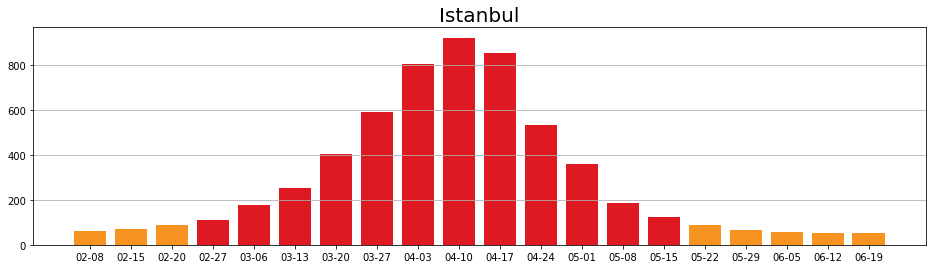

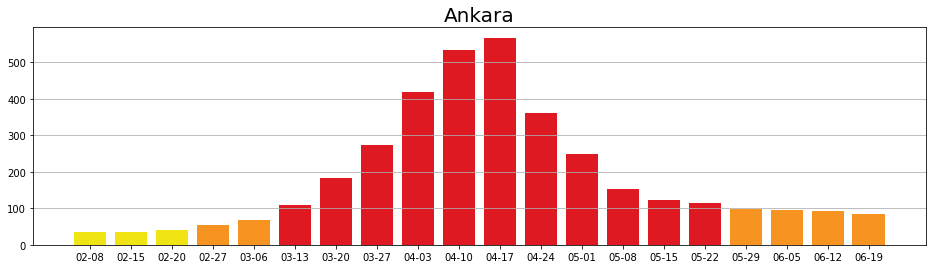

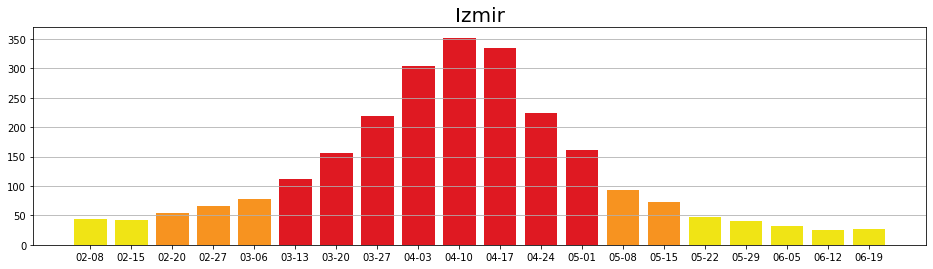

In [6]:
plot_city(df_turkey, 'Istanbul')
plot_city(df_turkey, 'Ankara')
plot_city(df_turkey, 'Izmir')
plt.show()

### General Stats

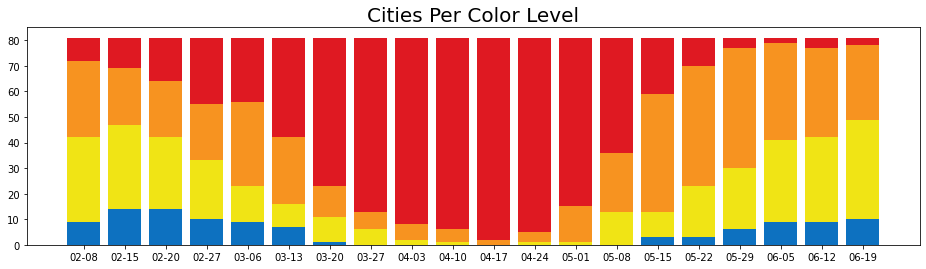

In [7]:
idx = pd.MultiIndex.from_product([df_turkey['date'].unique(), [0, 1, 2, 3]])

col = df_turkey.groupby(['date'])['color'].value_counts()
col = col.append(pd.Series(0, index=idx[~idx.isin(col.index)])).sort_index()

col.index = col.index.set_levels(pd.DatetimeIndex(col.index.levels[0], dayfirst=True), level=0)
col = col.sort_index()
col.index = col.index.set_levels(col.index.levels[0].strftime('%m-%d'), level=0)

X = col.index.get_level_values(0).unique()
Y0 = col.loc[pd.IndexSlice[:, 0],].values
Y1 = col.loc[pd.IndexSlice[:, 1],].values
Y2 = col.loc[pd.IndexSlice[:, 2],].values
Y3 = col.loc[pd.IndexSlice[:, 3],].values

fig, ax = plt.subplots(figsize=(16, 4))

ax.set_title('Cities Per Color Level', fontsize=20)

ax.bar(X, Y0, color=blue)
ax.bar(X, Y1, color=yellow, bottom=Y0)
ax.bar(X, Y2, color=orange, bottom=(Y0 + Y1))
ax.bar(X, Y3, color=red, bottom=(Y0 + Y1 + Y2))

plt.show()

### Map Plot

In [8]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 5.2MB/s 
     |████████████████████████████████| 6.6MB 17.1MB/s 
     |████████████████████████████████| 15.4MB 190kB/s 


In [9]:
import geopandas as gpd

In [10]:
turkey_map = gpd.read_file('https://raw.githubusercontent.com/aParsecFromFuture/COVID-19-stats/main/Turkey/datasets/turkey_regional_map.geojson')

date = '19.06.2021'
colors = ['#0d71c0', '#f0e415', '#f79320', '#df1922']

turkey_map['color'] = df_turkey.loc[df_turkey.date == date, 'color'].reset_index(drop='True')
turkey_map['case'] = df_turkey.loc[df_turkey.date == date, 'case'].reset_index(drop='True')

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:642: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


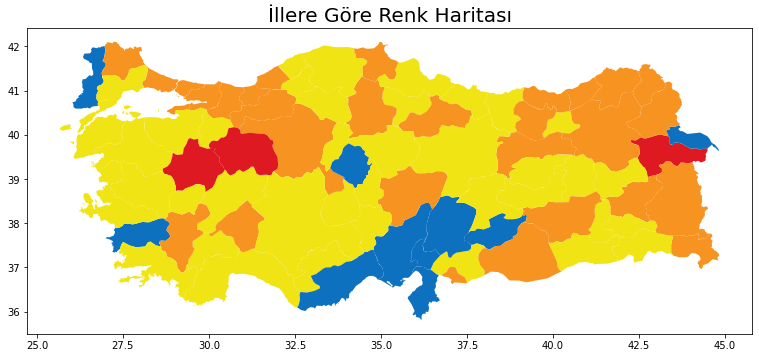

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))

ax.set_title('İllere Göre Renk Haritası', fontsize=20)

cmap = [colors[i] for i in turkey_map['color']]

turkey_map.plot(column='color', ax=ax, color=cmap)

plt.show()

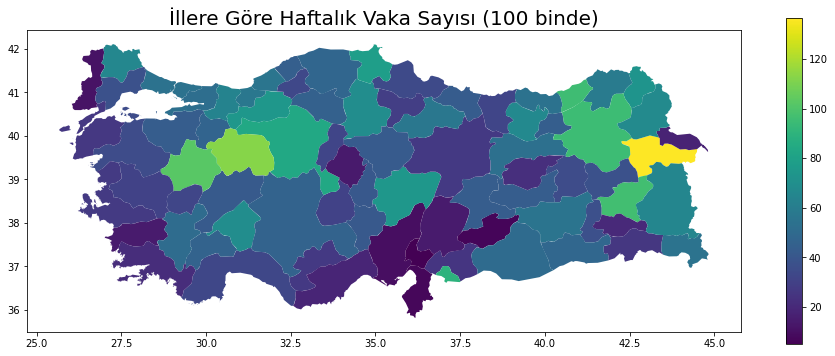

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

ax.set_title('İllere Göre Haftalık Vaka Sayısı (100 binde)', fontsize=20)

turkey_map.plot(column='case', ax=ax, legend=True, cmap='viridis')

plt.show()